In [1]:
%load_ext autoreload
%autoreload 2

from controllers import plan_trajectory
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gym.logger.set_level(gym.logger.ERROR)
env = gym.make('CarRacing-v1', seed=42).env
state = env.reset()
states, actions, observations = [], [], []
done = False

In [3]:
trajectory = plan_trajectory(env, T=60)
len(trajectory), trajectory

[planning.py] planning trajectory


(3000,
 array([[ 2.16983785e+02, -5.13294577e+01,  1.41532152e+00,
          2.75502530e+00,  1.75770657e+01,  0.00000000e+00],
        [ 2.17038886e+02, -5.09779164e+01,  1.41532152e+00,
          2.75502530e+00,  1.75770657e+01,  0.00000000e+00],
        [ 2.17093986e+02, -5.06263751e+01,  1.41532152e+00,
          2.75502530e+00,  1.75770657e+01,  0.00000000e+00],
        ...,
        [ 2.16653182e+02, -5.34387056e+01,  1.41532152e+00,
          5.51005060e+00,  3.51541314e+01, -2.22044605e-14],
        [ 2.16763383e+02, -5.27356230e+01,  1.41532152e+00,
          5.51005060e+00,  3.51541314e+01, -3.33066907e-14],
        [ 2.16873584e+02, -5.20325404e+01,  1.41532152e+00,
          5.51005060e+00,  3.51541314e+01, -2.22044605e-14]]))

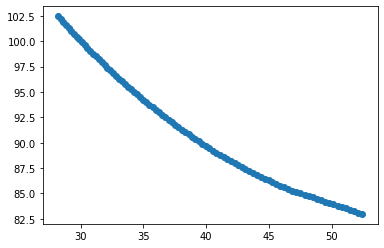

In [4]:
track = trajectory[700:790, :3]
plt.plot(track[:, 0], track[:, 1], '-o')
plt.show()

In [5]:
from casadi import *

# track = trajectory[:, :3]
z_ref = MX(track.T)
N = z_ref.shape[1]

Q = MX(np.diag([1, 1, 1]))
R = MX(np.eye(2)) / 100000

dt = 0.02
l = 1

In [6]:
opti = casadi.Opti();

z = opti.variable(4, N);
opti.set_initial(z[:3, :], track.T)

u = opti.variable(2, N-1);
u_init = np.tile([[0], [.5]], (1, N-1))
opti.set_initial(u, u_init)

cost = sum([(z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i] for i in range(N-1)]) \
        + (z[:3, N-1] - z_ref[:, N-1]).T @ Q @ (z[:3, N-1] - z_ref[:, N-1])

opti.minimize(cost);
# opti.subject_to(-1 <= u[0, :] <= 1);
# opti.subject_to(-1 <= z[2, :] <= 1);
# opti.subject_to(-3 <= u[1, :] <= 3);
# opti.subject_to(0 <= u[2, :] <= 1);

opti.subject_to([(z[0, i+1] - z[0, i]) / dt == u[0, i] * np.cos(z[2, i]) for i in range(N-1)]);
opti.subject_to([(z[1, i+1] - z[1, i]) / dt == u[0, i] * np.sin(z[2, i]) for i in range(N-1)]);
opti.subject_to([(z[2, i+1] - z[2, i]) / dt == u[0, i] / l * np.tan(z[3, i]) for i in range(N-1)]);
opti.subject_to([(z[3, i+1] - z[3, i]) / dt == u[1, i] for i in range(N-1)]);
opti.subject_to(u[:, 0] == 0)
opti.subject_to(z[:3, 0] == z_ref[:, 0])

opti.solver('ipopt');

sol = opti.solve();

In [7]:
z_opt = sol.value(z)
u_opt = sol.value(u)

plt.plot(track[:, 0], track[:, 1], '-o')
plt.plot(z_opt[0, :], z_opt[1, :], '-+')
plt.show()

In [8]:
print(u_opt)

In [9]:
u_T = u_opt.T
racecar_action = np.zeros((N-1, 3))  # third coumn is brake. It is null because 
# it is not in the bicycle model used in the optimization solve
racecar_action[:, 0] = z_opt.T[:-1, 3]  # steering
racecar_action[:, 1] = u_T[:, 0]  # throttle

racecar_action

In [10]:
# for action in racecar_action:
#     try:
#         # render environment 
#         env.render()

#         observation = env.step(action)
#     except KeyboardInterrupt:
#         done = True

In [11]:
# def f(z, u, model):
#     tensor = vertcat(z, u)
#     layers = model.get_weights()
#     L = len(layers)

#     for i in range(0, L, 2):
#         weight, bias = MX(layers[i].T), MX(layers[i+1])

#         if i < L-2:
#             tensor = tanh(weight @ tensor + bias)
#         else:
#             tensor = weight @ tensor + bias

#     return tensor

In [12]:
# from learning import load_model

Using TensorFlow backend.


In [13]:
# model = load_model("../models/dynamics64.h5")

[learning.py] loading model (../models/dynamics64.h5)
__________________________________________________________________________________________________
Model: "dynamics"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 6)            0                                            
__________________________________________________________________________________________________
u (InputLayer)                  (None, 3)            0                                            
__________________________________________________________________________________________________
input_layer (Concatenate)       (None, 9)            0           z[0][0]                          
                                                                 u[0][0]                          
_____________________________________

In [14]:
from casadi import *

z_ref = MX(track.T)
N = z_ref.shape[1]

Q = MX(np.diag([1, 1, 1]))
R = MX(np.eye(3)) / 100000

dt = 0.02

In [15]:
# opti = casadi.Opti();

# u = opti.variable(3, N-1);
# u_init = np.tile([[0], [.5], [0]], (1, N-1))
# opti.set_initial(u, u_init)

# z = MX(6, N)
# z[3:, 0] = np.zeros((3, 1))
# z[:3, 0] = track.T[:3, 0]
# cost = 0

# for i in range(N-1):
#     cost += (z[:3, i] - z_ref[:, i]).T @ Q @ (z[:3, i] - z_ref[:, i]) + u[:, i].T @ R @ u[:, i]
#     # z = f(z, u[:, i:i+1], model)
#     z[:3, i+1] = z[:3, i] + z[3:, i] * dt
#     z[3:, i+1] = z[3:, i] + f(z[:, i], u[:, i], model) * dt

# cost += (z[:3, N-1] - z_ref[:, N-1]).T @ Q @ (z[:3, N-1] - z_ref[:, N-1])

# opti.minimize(cost);

# opti.solver('ipopt');

# sol = opti.solve();


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    35778

Total number of variables............................:      267
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  2.0711298e+04 0.00e+00 5.56e+01  -1.0 2.23e-05   6.4 1.00e+00 1.00e+00f  1
  81  2.0677387e+04 0.00e+00 6.16e+01  -1.0 6.87e-05   6.0 1.00e+00 1.00e+00f  1
  82  2.0600459e+04 0.00e+00 6.83e+01  -1.0 2.28e-04   5.5 1.00e+00 1.00e+00f  1
  83  2.0199234e+04 0.00e+00 1.88e+02  -1.0 8.21e-04   5.0 1.00e+00 1.00e+00f  1
  84  2.0047742e+04 0.00e+00 1.82e+02  -1.0 1.27e-04   6.3 1.00e+00 1.00e+00f  1
  85  1.9862563e+04 0.00e+00 1.49e+02  -1.0 6.72e-04   5.9 1.00e+00 1.00e+00f  1
  86  1.9852913e+04 0.00e+00 1.53e+02  -1.0 1.01e-05   7.2 1.00e+00 1.00e+00f  1
  87  1.9822330e+04 0.00e+00 1.79e+02  -1.0 3.69e-05   6.7 1.00e+00 1.00e+00f  1
  88  1.9638171e+04 0.00e+00 3.11e+02  -1.0 8.23e-04   6.2 1.00e+00 1.00e+00f  1
  89  1.9468393e+04 0.00e+00 8.45e+01  -1.0 1.14e-04   6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  1.9423613e+04 0.00e+00

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:159:
.../casadi/core/optistack_internal.cpp:999: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'NonIpopt_Exception_Thrown'

In [ ]:
# u_opt = sol.value(u)

# # z = z_0.squeeze()
# # zs = [z]

# # for i in range(N-1):
# #     a = model.predict([z.reshape(1, -1), u_opt[:, i].reshape(1, -1)])[0]
# #     z_next = np.zeros((6,))
# #     z_next[:3] = z[:3] + z[3:] * dt
# #     z_next[3:] = z[3:] + a * dt
# #     zs.append(z_next)
# #     z = z_next

# # zs = np.array(zs)

# zs = sol.value(z).T

# plt.plot(track[:, 0], track[:, 1], '-o')
# plt.plot(zs[:, 0], zs[:, 1], '-+')
# plt.show()